In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pslib import *
import imageio

In [2]:
gaussian_kernel = np.load('gaussian-kernel.npy')

In [3]:
def convolution(img, kernel):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    kernel_size = kernel.shape[0]
    pad_amount = int(kernel_size/2)
    gaussian_convolved_img = np.zeros(img.shape)
    for i in range(3):
        zero_padded = np.pad(img[:,:,i], u_pad=pad_amount, v_pad=pad_amount)
        for r in range(pad_amount, MAX_ROWS+pad_amount):
            for c in range(pad_amount, MAX_COLS+pad_amount):
    #             print("r-pad_amount", r-pad_amount)
    #             print("r-pad_amount+kernel_size", r-pad_amount+kernel_size)
                conv = np.multiply(zero_padded[r-pad_amount:r-pad_amount+kernel_size, c-pad_amount:c-pad_amount+kernel_size],kernel)
                conv = np.sum(conv)
                gaussian_convolved_img[r-pad_amount, c-pad_amount, i] = float(conv)
    return gaussian_convolved_img

In [4]:
def make_one_D_kernel(kernel,img):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    one_d_gaussian_kernel = kernel
    
    kernel_matrix = np.zeros((MAX_ROWS, MAX_ROWS))
    # print(kernel_matrix.shape)
    for m in range(MAX_ROWS):
    #     print(m)
    #     print(m+(len(one_d_gaussian_kernel)))
    #     print(one_d_gaussian_kernel)
    #     print()
        over = int(len(one_d_gaussian_kernel)/2)
        mid = over
        lower = max(0,m-over)
        upper = min(m+over, MAX_ROWS)
        kernel_lower = mid-over if m-over >= 0 else abs(m-over)
        kernel_upper = mid+over if m+over < MAX_ROWS else (mid+over)-(m+over-MAX_ROWS)
        kernel_matrix[m, lower:upper] = one_d_gaussian_kernel[kernel_lower:kernel_upper]
    return kernel_matrix

In [5]:
def down_sample(img, factor=2):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    small_img = np.zeros((int(MAX_ROWS/2), int(MAX_COLS/2), 3))
    
    small_img[:,:,0]=np.resize(image=img[:,:,0], size=[int(MAX_ROWS/2), int(MAX_COLS/2)])
    small_img[:,:,1]=np.resize(image=img[:,:,1], size=[int(MAX_ROWS/2), int(MAX_COLS/2)])
    small_img[:,:,2]=np.resize(image=img[:,:,2], size=[int(MAX_ROWS/2), int(MAX_COLS/2)])
    return small_img

In [6]:
def up_sample(img, factor=2):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    small_img = np.zeros((int(MAX_ROWS*2), int(MAX_COLS*2), 3))
    
    small_img[:,:,0]=np.resize(image=img[:,:,0], size=[int(MAX_ROWS*2), int(MAX_COLS*2)])
    small_img[:,:,1]=np.resize(image=img[:,:,1], size=[int(MAX_ROWS*2), int(MAX_COLS*2)])
    small_img[:,:,2]=np.resize(image=img[:,:,2], size=[int(MAX_ROWS*2), int(MAX_COLS*2)])
    return small_img

In [7]:
def one_level_laplacian(img,G):
    # generate Gaussian pyramid for Apple
    A = img.copy()

    # Gaussian blur on Apple
    blurred_A = convolution(A, G)

    # Downsample blurred A
    small_A = down_sample(blurred_A)

    # Upsample small, blurred A
    # insert zeros between pixels, then apply a gaussian low pass filter
    large_A = up_sample(small_A)
    upsampled_A = convolution(large_A, G)

    # generate Laplacian level for A
    laplace_A = A - upsampled_A

    # reconstruct A
#     reconstruct_A = laplace_A + upsampled_A
    
    return small_A, upsampled_A, laplace_A

In [8]:
def F_transform(small_A, G):
    large_A = up_sample(small_A)
    upsampled_A = convolution(large_A, G)
    return upsampled_A

In [9]:
def gamma_decode(img):
    new_img = np.zeros((img.shape))
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            new_img[r,c,0] = np.power(img[r,c,0], 1/1.2)
            new_img[r,c,1] = np.power(img[r,c,1], 1/1.2)
            new_img[r,c,2] = np.power(img[r,c,2], 1/1.2)
    return new_img

In [14]:
img = imageio.imread('apple.png')
img = gamma_decode(img)

C:\Users\User\AppData\Local\Temp\ipykernel_2616\2430508426.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('apple.png')


[[[68.31209486 72.22830686 46.41588834]
  [68.31209486 72.22830686 46.41588834]
  [68.31209486 71.16455303 47.57341786]
  ...
  [80.2843861  82.01393667 66.51719609]
  [80.2843861  81.66861461 67.23630397]
  [81.32300027 82.70371084 68.31209486]]

 [[67.59528088 71.51948877 45.64099073]
  [67.59528088 71.51948877 45.64099073]
  [67.9538769  70.80926287 47.18820707]
  ...
  [76.10248048 77.85038898 62.16896258]
  [76.45269926 77.85038898 63.26157524]
  [77.85038898 79.24307761 64.71255648]]

 [[66.15705928 70.45361581 46.80236632]
  [66.15705928 70.45361581 46.80236632]
  [66.15705928 70.09760934 47.57341786]
  ...
  [71.87407258 73.64179632 57.7589727 ]
  [72.58219403 73.99431838 59.23621926]
  [74.34650486 75.75193907 61.0724956 ]]

 ...

 [[57.7589727  67.23630397 61.0724956 ]
  [58.12898589 67.59528088 61.43841876]
  [58.12898589 67.59528088 62.16896258]
  ...
  [52.90396448 72.22830686 69.02740761]
  [53.65651575 72.22830686 69.38450784]
  [56.64606775 75.04987996 72.22830686]]

 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


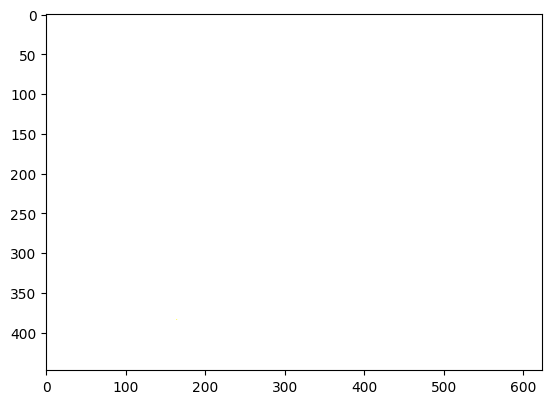

In [11]:
plt.imshow(img)
plt.show()

In [12]:
img.shape

(448, 624, 3)

In [13]:
MAX_ROWS = img.shape[0]
MAX_COLS = img.shape[1]
print("MAX_ROWS = ", MAX_ROWS)
print("MAX_COLS = ", MAX_COLS)

MAX_ROWS =  448
MAX_COLS =  624
